In [4]:
import numpy as np
import pandas as pd
import requests
from rates_processing import *
from cds_processing import *
import config
from pathlib import Path
from pandas.tseries.offsets import MonthEnd

OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)

In [5]:
start_date = '2001-01-02'
end_date = '2024-01-31'


In [6]:
def calc_cds_return(start_date, end_date,Method):

    loss_given_default =0.6

    quarterly_discount = calc_discount(start_date, end_date)
    quarterly_discount = quarterly_discount[:-1]

    cds_spread = process_cds_monthly(method=Method)
    cds_spread= cds_spread.bfill()
    cds_spread = cds_spread.set_index('Date')
    cds_spread.index = pd.to_datetime(cds_spread.index)

    lambda_df = 4 * np.log(1+(cds_spread/(4*loss_given_default)))
    quarters = range(1, 21)  # 1 to 20 quarters
    risky_duration = pd.DataFrame(index=lambda_df.index, columns=lambda_df.columns)
    for col in lambda_df.columns:
        quarterly_survival_probability = pd.DataFrame(index=lambda_df.index, columns=quarters)
        for quarter in quarters:
            quarterly_survival_probability[quarter] = np.exp(-((quarter * lambda_df[col]) / 4))
        temp_df = quarterly_survival_probability * quarterly_discount
        risky_duration[col] = 0.25 * temp_df.sum(axis=1)
    risky_duration_shifted = risky_duration.shift(1)
    cds_spread_shifted = cds_spread.shift(1)
    cds_spread_change = cds_spread.diff()
    cds_return = ((cds_spread_shifted/12) + (cds_spread_change * risky_duration_shifted))
    return cds_return

In [7]:
cal_returns = calc_cds_return(start_date, end_date,'mean')
cal_returns*100

,cds_1,cds_2,cds_3,cds_4,cds_5,cds_6,cds_7,cds_8,cds_9,cds_10,cds_11,cds_12,cds_13,cds_14,cds_15,cds_16,cds_17,cds_18,cds_19,cds_20
Date,,,,,,,,,,,,,,,,,,,,
2001-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-02-28,-0.014414,-0.053539,0.023634,0.045065,0.020558,0.105248,0.076332,0.134388,0.244493,0.276419,0.350415,0.302937,0.330850,0.885351,0.778880,0.552421,0.246351,0.271367,1.931845,0.779156
2001-03-31,0.014565,0.035308,-0.047742,-0.057028,-0.126691,-0.074207,0.054370,0.118613,0.081574,-0.060370,-0.161928,-0.199382,-0.206227,-0.750157,-0.312734,0.016034,0.010594,-0.736950,-2.139687,0.779156
2001-04-30,0.020712,0.026811,0.013212,0.024842,-0.025252,-0.081603,-0.065130,0.101261,0.041007,0.036778,0.040427,-0.025847,-0.066323,0.470733,0.185384,0.333558,1.229171,1.525224,1.491790,0.779156
2001-05-31,-0.026517,-0.046768,-0.077798,-0.057646,-0.047747,-0.052601,-0.009948,-0.190674,-0.167972,-0.164117,-0.217357,-0.078367,0.107171,-0.296413,-0.193408,-0.005596,-0.363012,-0.174143,-0.515698,0.779156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.006371,-0.006798,0.036651,0.017312,0.016096,0.017975,0.027829,0.017110,0.061985,0.046617,0.034133,0.083371,0.148743,0.217293,0.141879,0.112009,0.134821,0.312558,0.513400,0.003078
2023-09-30,0.040112,0.113489,0.105694,0.150764,0.181707,0.219028,0.178992,0.250221,0.266729,0.316851,0.368655,0.348521,0.258803,0.544112,0.612352,0.722913,0.854354,1.269396,1.532420,1.580480
2023-10-31,0.012740,0.082170,0.102990,0.100374,0.140542,0.142176,0.135942,0.131650,0.192728,0.232739,0.259789,0.266811,0.251242,0.257506,0.384370,0.336865,0.450282,0.796371,1.139536,1.580480


In [8]:
def process_real_cds_return():
    actual_return = pd.read_csv('~/Documents/GitHub/P15_DANK/data/manual/He_Kelly_Manela_Factors_And_Test_Assets_monthly.csv')
    actual_return = actual_return[['yyyymm','CDS_01','CDS_02','CDS_03','CDS_04','CDS_05','CDS_06','CDS_07','CDS_08','CDS_09','CDS_10','CDS_11','CDS_12','CDS_13','CDS_14','CDS_15','CDS_16','CDS_17','CDS_18','CDS_19','CDS_20']]
    actual_return = actual_return.dropna(axis=0)
    actual_return['yyyymm'] = pd.to_datetime(actual_return['yyyymm'], format='%Y%m')
    actual_return['yyyymm']= actual_return['yyyymm'] + MonthEnd(1)
    actual_return = actual_return.set_index('yyyymm')
    return actual_return

In [9]:
actual_return = process_real_cds_return()
actual_return

,CDS_01,CDS_02,CDS_03,CDS_04,CDS_05,CDS_06,CDS_07,CDS_08,CDS_09,CDS_10,CDS_11,CDS_12,CDS_13,CDS_14,CDS_15,CDS_16,CDS_17,CDS_18,CDS_19,CDS_20
yyyymm,,,,,,,,,,,,,,,,,,,,
2001-02-28,0.0039,0.0040,0.0033,0.0024,0.0093,0.0030,0.0020,0.0048,0.0044,0.0039,0.0078,-0.0036,0.0042,0.0057,0.0027,-0.0153,-0.0032,0.0070,0.0005,0.0193
2001-03-31,0.0012,0.0041,0.0061,0.0045,0.0073,0.0059,0.0079,0.0071,0.0087,-0.0112,0.0060,0.0042,0.0032,0.0068,-0.0012,0.0093,0.0083,-0.0012,0.0072,0.0219
2001-04-30,0.0033,0.0044,0.0044,0.0060,0.0054,0.0037,0.0044,0.0044,0.0068,0.0021,0.0098,0.0106,0.0084,0.0098,0.0083,0.0124,0.0061,0.0109,0.0041,-0.0018
2001-05-31,0.0038,0.0043,0.0045,0.0039,0.0044,0.0039,0.0040,0.0075,0.0045,0.0034,0.0076,0.0078,0.0049,0.0117,0.0108,0.0061,0.0150,0.0152,0.0184,0.0140
2001-06-30,0.0030,0.0027,0.0044,0.0037,0.0079,0.0042,0.0053,0.0035,0.0040,0.0011,0.0031,0.0029,0.0038,0.0045,0.0034,0.0044,0.0020,0.0073,0.0065,-0.0007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-31,0.0005,0.0009,0.0013,0.0011,0.0022,0.0022,0.0024,0.0017,0.0015,0.0026,0.0031,0.0015,0.0035,0.0032,0.0043,0.0062,0.0084,0.0060,0.0051,0.0152
2012-09-30,0.0012,0.0010,0.0020,0.0022,0.0030,0.0023,0.0030,0.0033,0.0039,0.0045,0.0049,0.0059,0.0057,0.0087,0.0070,0.0083,0.0092,0.0120,0.0119,0.0174
2012-10-31,0.0010,0.0009,0.0009,0.0016,0.0018,0.0019,0.0014,0.0010,0.0019,0.0010,0.0008,0.0028,0.0043,0.0042,0.0013,0.0045,0.0033,0.0028,-0.0010,0.0045


<Axes: xlabel='Date'>

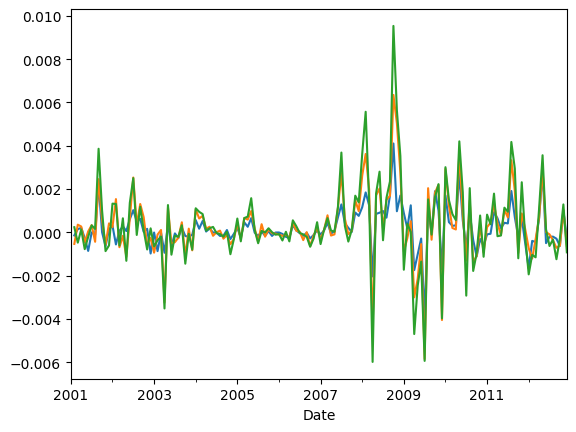

In [10]:
cds_return_paper = cal_returns[cal_returns.index <= '2012-12-31']
cds_return_paper['cds_1'].plot()
cds_return_paper['cds_2'].plot()
cds_return_paper['cds_3'].plot()

<Axes: xlabel='yyyymm'>

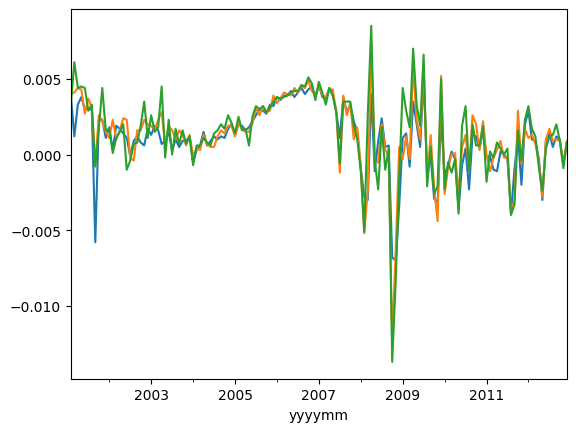

In [11]:
actual_return['CDS_01'].plot()
actual_return['CDS_02'].plot()
actual_return['CDS_03'].plot()

In [16]:
cds_return_paper = cds_return_paper.dropna(axis=0)

In [21]:
actual_return_reindexed = actual_return.reindex(cds_return_paper.index)

actual_return_reindexed.columns = cds_return_paper.columns
actual_return_reindexed

,cds_1,cds_2,cds_3,cds_4,cds_5,cds_6,cds_7,cds_8,cds_9,cds_10,cds_11,cds_12,cds_13,cds_14,cds_15,cds_16,cds_17,cds_18,cds_19,cds_20
Date,,,,,,,,,,,,,,,,,,,,
2001-02-28,0.0039,0.0040,0.0033,0.0024,0.0093,0.0030,0.0020,0.0048,0.0044,0.0039,0.0078,-0.0036,0.0042,0.0057,0.0027,-0.0153,-0.0032,0.0070,0.0005,0.0193
2001-03-31,0.0012,0.0041,0.0061,0.0045,0.0073,0.0059,0.0079,0.0071,0.0087,-0.0112,0.0060,0.0042,0.0032,0.0068,-0.0012,0.0093,0.0083,-0.0012,0.0072,0.0219
2001-04-30,0.0033,0.0044,0.0044,0.0060,0.0054,0.0037,0.0044,0.0044,0.0068,0.0021,0.0098,0.0106,0.0084,0.0098,0.0083,0.0124,0.0061,0.0109,0.0041,-0.0018
2001-05-31,0.0038,0.0043,0.0045,0.0039,0.0044,0.0039,0.0040,0.0075,0.0045,0.0034,0.0076,0.0078,0.0049,0.0117,0.0108,0.0061,0.0150,0.0152,0.0184,0.0140
2001-06-30,0.0030,0.0027,0.0044,0.0037,0.0079,0.0042,0.0053,0.0035,0.0040,0.0011,0.0031,0.0029,0.0038,0.0045,0.0034,0.0044,0.0020,0.0073,0.0065,-0.0007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-08-31,0.0005,0.0009,0.0013,0.0011,0.0022,0.0022,0.0024,0.0017,0.0015,0.0026,0.0031,0.0015,0.0035,0.0032,0.0043,0.0062,0.0084,0.0060,0.0051,0.0152
2012-09-30,0.0012,0.0010,0.0020,0.0022,0.0030,0.0023,0.0030,0.0033,0.0039,0.0045,0.0049,0.0059,0.0057,0.0087,0.0070,0.0083,0.0092,0.0120,0.0119,0.0174
2012-10-31,0.0010,0.0009,0.0009,0.0016,0.0018,0.0019,0.0014,0.0010,0.0019,0.0010,0.0008,0.0028,0.0043,0.0042,0.0013,0.0045,0.0033,0.0028,-0.0010,0.0045


In [23]:
diff = actual_return_reindexed - cds_return_paper

In [25]:
diff.describe()

,cds_1,cds_2,cds_3,cds_4,cds_5,cds_6,cds_7,cds_8,cds_9,cds_10,cds_11,cds_12,cds_13,cds_14,cds_15,cds_16,cds_17,cds_18,cds_19,cds_20
count,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000,143.000000
mean,0.000944,0.001060,0.001108,0.000955,0.001169,0.000972,0.000886,0.001118,0.000897,0.000577,0.000860,0.000582,0.000449,0.000361,-0.000250,0.000137,-0.000066,-0.000699,-0.001355,-0.008147
std,0.002880,0.003732,0.004407,0.005132,0.005448,0.006011,0.006194,0.007160,0.008084,0.009439,0.011416,0.012498,0.014245,0.016406,0.019444,0.022320,0.025705,0.033369,0.046712,0.033417
min,-0.010904,-0.018747,-0.023235,-0.027756,-0.023352,-0.030228,-0.025973,-0.035792,-0.041623,-0.045646,-0.061339,-0.070488,-0.086267,-0.090111,-0.113856,-0.128468,-0.135853,-0.159645,-0.205949,-0.181836
25%,-0.000045,-0.000388,-0.000468,-0.001012,-0.000776,-0.001420,-0.001582,-0.001488,-0.001757,-0.001639,-0.002706,-0.002513,-0.003498,-0.004294,-0.007618,-0.007905,-0.009879,-0.010551,-0.014212,-0.019671
50%,0.001308,0.001555,0.001724,0.001949,0.001870,0.001964,0.002249,0.002107,0.001991,0.001821,0.002343,0.002233,0.002261,0.002230,0.002389,0.001086,0.003172,0.002718,0.005236,-0.006354
75%,0.002859,0.003198,0.003356,0.003808,0.004210,0.004138,0.004153,0.004430,0.004496,0.004657,0.005195,0.005720,0.006515,0.007795,0.007544,0.008984,0.010810,0.013192,0.018549,0.007011
max,0.009083,0.011852,0.014487,0.015045,0.017849,0.017910,0.021742,0.023127,0.026134,0.034683,0.041985,0.044084,0.049081,0.060003,0.065559,0.070999,0.097023,0.114187,0.158417,0.086776
